In [1]:
from datetime import datetime
import numpy as np
import yaml

from IPython.display import Image, display
import ROOT

In [22]:
# Intialise the files
with open('./analysis_config.yaml', "r") as config_file:
        config = yaml.safe_load(config_file)

filenameslist = []
filetypeslist = []
for s_name, s_info in config['samples'].items():
    filenameslist += [f'./OutHistoFiles/hists_{s_name}.root']
    filetypeslist += [s_info['type']]

colourlist = [ROOT.kRed, ROOT.kRed+2, ROOT.kYellow+4, ROOT.kYellow-1, ROOT.kYellow-5, ROOT.kYellow-6, ROOT.kYellow-8]
open_infiles = [ROOT.TFile.Open(filename) for filename in filenameslist]

print(filenameslist, filetypeslist)

['./OutHistoFiles/hists_DYToLL_M50_PU0.root', './OutHistoFiles/hists_DYToLL_M50_PU200.root', './OutHistoFiles/hists_QCD_Pt20To30.root', './OutHistoFiles/hists_QCD_Pt30To50.root', './OutHistoFiles/hists_QCD_Pt50To80.root', './OutHistoFiles/hists_QCD_Pt80To120.root', './OutHistoFiles/hists_QCD_Pt120To170.root'] ['dytoll', 'dytoll', 'qcd', 'qcd', 'qcd', 'qcd', 'qcd']


In [46]:
def plotmc(varlist, binedges, *, logy=False, logx=False, normalise=False):
    # Create a canvas
    now_str = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    binedges = np.array(binedges, dtype=np.float64)

    c = ROOT.TCanvas("c"+now_str, "c"+now_str, 800, 600)
    ROOT.gStyle.SetOptStat(0)
    if logy:
        c.SetLogy()
    if logx:
        c.SetLogx()
    legend = ROOT.TLegend(0.6, 0.7, 0.8, 0.9)

    varhists = [file.Get(varlist[i]) for i, file in enumerate(open_infiles)]
    var = varlist[0].split('_')[0]

    for i, hist in enumerate(varhists):
        newhist = hist.Rebin(len(binedges)-1, var+'_rebinned', binedges)
        #Include underflow and overflow
        newhist.GetXaxis().SetRange(0, newhist.GetNbinsX()+1)

        newhist.GetXaxis().SetTitle(newhist.GetTitle())
        if normalise:
            newhist.GetYaxis().SetTitle("normalised events")
        else:
            newhist.GetYaxis().SetTitle("events")
        newhist.SetTitle('')

        newhist.SetLineColor(colourlist[i])
        newhist.SetLineWidth(4)

        if normalise:
            newhist.Scale(1.0 / newhist.Integral())
            

        newhist.Draw("HIST SAME E1")

        legend.AddEntry(newhist, filenameslist[i][22:-5], "l")

    legend.Draw()
    c.Update()

    plotname = f"nb_plots/{var}_{now_str}.png"
    c.SaveAs(plotname)
    return plotname

In [40]:
def ploteff(refvar, targetvar, binedges, *, logy=False, logx=False):
    # Create a canvas
    now_str = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    binedges = np.array(binedges, dtype=np.float64)

    c = ROOT.TCanvas("c"+now_str, "c"+now_str, 800, 600)
    ROOT.gStyle.SetOptStat(0)
    c.Divide(2, 2)

    refvarhists = [file.Get(refvar) for i, file in enumerate(open_infiles) if filetypeslist[i] == 'dytoll']
    targetvarhists = [file.Get(targetvar) for i, file in enumerate(open_infiles) if filetypeslist[i] == 'dytoll']
    plot_eff = [None]*len(refvarhists)

    for i, _ in enumerate(refvarhists):
        if i > 3: 
            break
        c.cd(2*i+1)
        if logy:
            ROOT.gPad.SetLogy()
        if logx:
            ROOT.gPad.SetLogx()
        ROOT.gPad.SetGrid()
        
        newrefvarhist = refvarhists[i].Rebin(len(binedges)-1, refvar+'_rebinned', binedges)
        newtargetvarhist = targetvarhists[i].Rebin(len(binedges)-1, targetvar+'_rebinned', binedges)

        newrefvarhist.GetXaxis().SetTitle(newrefvarhist.GetTitle())
        newrefvarhist.GetYaxis().SetTitle('events')
        newrefvarhist.SetTitle('')

        newrefvarhist.SetLineColor(ROOT.kBlue)
        newrefvarhist.SetLineWidth(2)
        newtargetvarhist.SetLineColor(ROOT.kRed)
        newtargetvarhist.SetLineWidth(2)

        newrefvarhist.SetMinimum(1) 

        newrefvarhist.Draw("HIST SAME E1")
        newtargetvarhist.Draw("HIST SAME E1")

        c.cd(2*i+2)
        if logx:
            ROOT.gPad.SetLogx()
        ROOT.gPad.SetGrid()
        
        plot_eff[i] = ROOT.TEfficiency(newtargetvarhist, newrefvarhist)

        plot_eff[i].SetLineWidth(2)

        plot_eff[i].Draw("AP")

        ROOT.gPad.Update()
        plot_eff[i].GetPaintedGraph().SetMinimum(0.0)
        plot_eff[i].GetPaintedGraph().SetMaximum(1.1)

        c.Update()

    plotname = f"nb_plots/comapre_{targetvar}_{now_str}.png"
    c.SaveAs(plotname)
    return plotname   

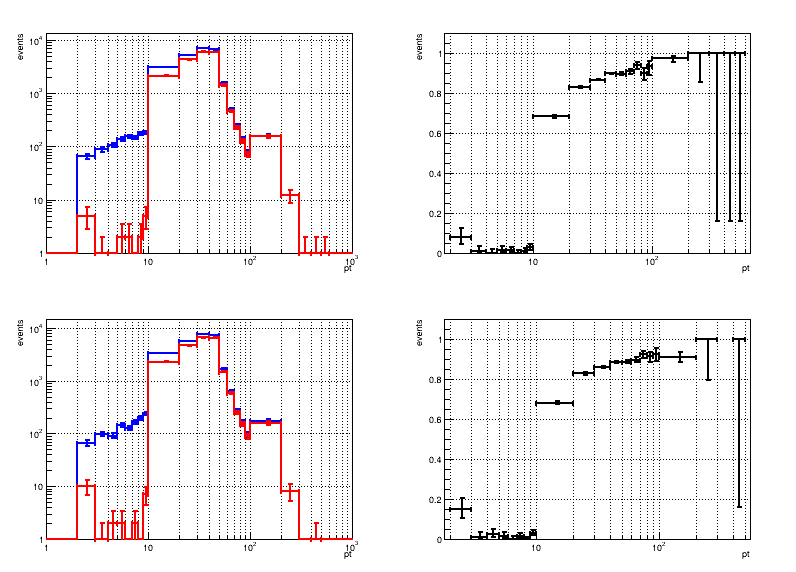

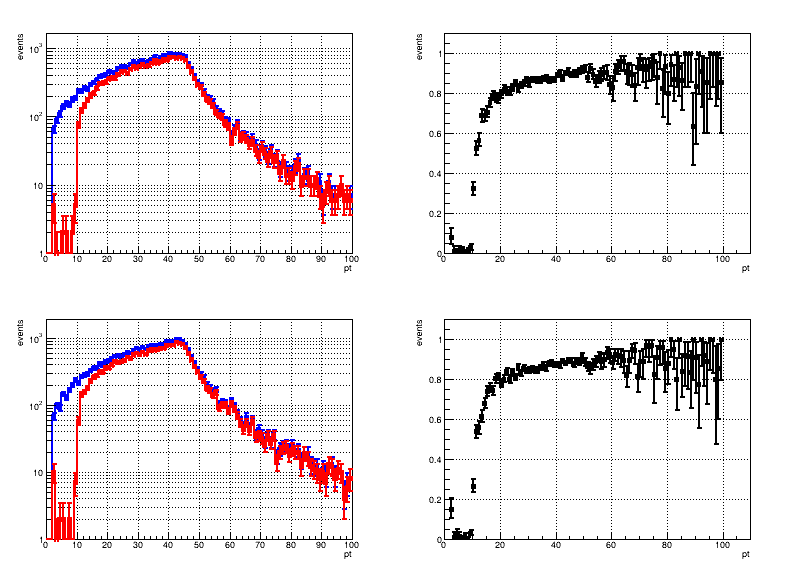

Info in <TCanvas::Print>: png file nb_plots/comapre_GenElgenEB_TkEleL2matched_pt_2025_04_30_15_42_51.png has been created
Info in <TCanvas::Print>: png file nb_plots/comapre_GenElgenEB_TkEleL2matched_pt_2025_04_30_15_42_51.png has been created


In [41]:
pteff = ploteff('GenElgenEB_pt', 'GenElgenEB_TkEleL2matched_pt', 
                np.concatenate( (np.arange(1, 10, 1), np.arange(10, 100, 10), np.arange(100, 1100, 100)) ),
                logy=True, logx=True)
display(Image(filename=pteff))
pteff = ploteff('GenElgenEB_pt', 'GenElgenEB_TkEleL2matched_pt', 
                np.arange(0, 101, 1),
                logy=True, logx=False)
display(Image(filename=pteff))

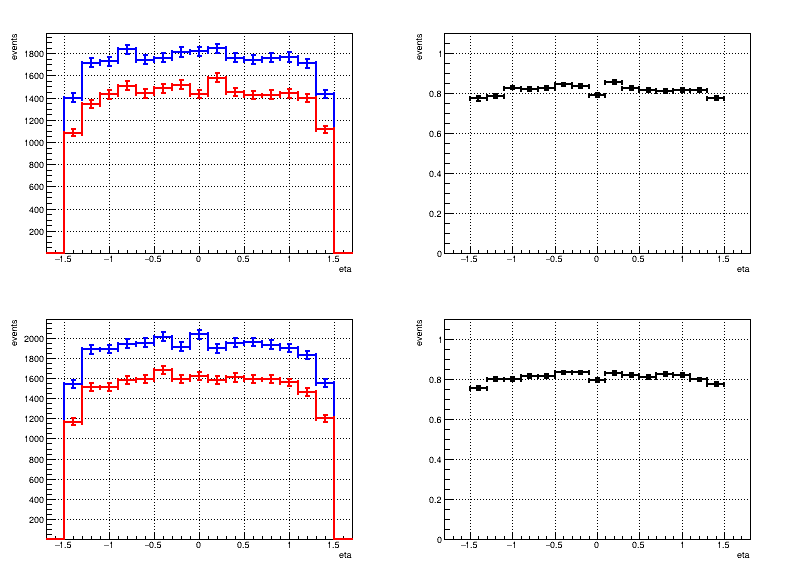

Info in <TCanvas::Print>: png file nb_plots/comapre_GenElgenEB_TkEleL2matched_eta_2025_04_30_15_43_01.png has been created


In [42]:
etaeff = ploteff('GenElgenEB_eta', 'GenElgenEB_TkEleL2matched_eta', np.arange(-1.7, 1.9, 0.2))
display(Image(filename=etaeff))

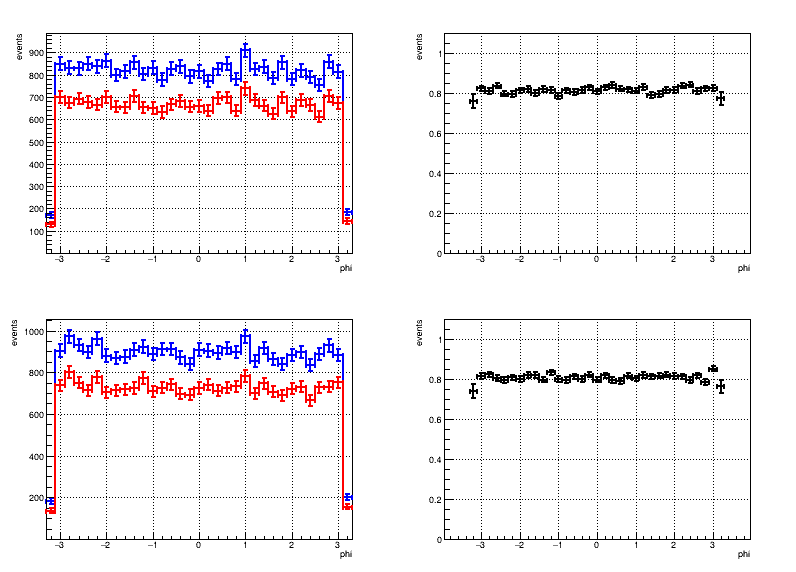

Info in <TCanvas::Print>: png file nb_plots/comapre_GenElgenEB_TkEleL2matched_phi_2025_04_30_15_43_21.png has been created


In [44]:
phieff = ploteff('GenElgenEB_phi', 'GenElgenEB_TkEleL2matched_phi', np.arange(-3.3, 3.5, 0.2))
display(Image(filename=phieff))

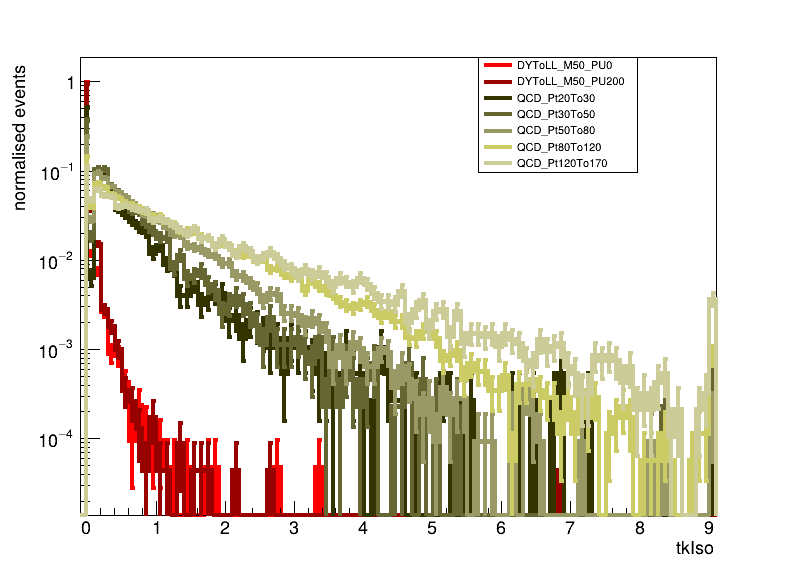

Info in <TCanvas::Print>: png file nb_plots/TkEleL2_2025_04_30_15_45_26.png has been created


In [47]:
tkisovarlist = ['TkEleL2_GenElgenEBmatched_tkIso']*2 + ['TkEleL2TkElPt10EB_tkIso']*5
tkisoplot = plotmc(tkisovarlist, 
                   np.concatenate((np.arange(0,0.01, 0.01), np.arange(0.01, 9.1, 0.1) )), 
                   logy=True, normalise=True)
display(Image(filename=tkisoplot))

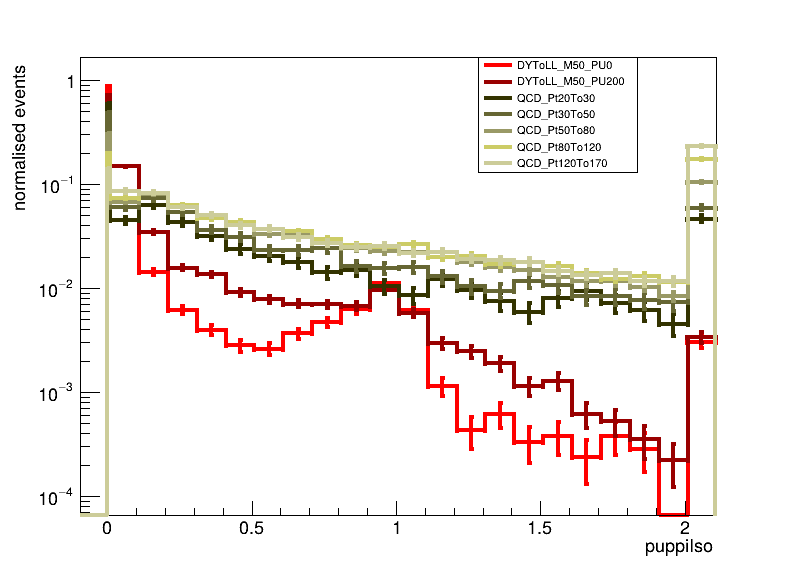

Info in <TCanvas::Print>: png file nb_plots/TkEleL2_2025_04_30_15_45_45.png has been created


In [48]:
puppiisovarlist = ['TkEleL2_GenElgenEBmatched_puppiIso']*2 + ['TkEleL2TkElPt10EB_puppiIso']*5
puppiisoplot = plotmc(puppiisovarlist, 
                      np.concatenate((np.arange(0,0.01, 0.01), np.arange(0.01, 2.11, 0.1) )), 
                      logy=True, normalise=True)
display(Image(filename=puppiisoplot))

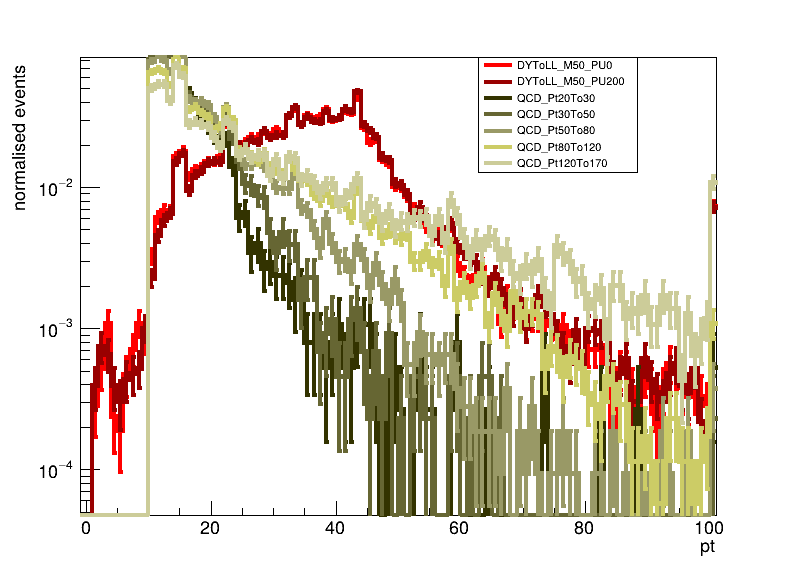

Info in <TCanvas::Print>: png file nb_plots/TkEleL2_2025_04_30_15_45_48.png has been created


In [49]:
ptvarlist = ['TkEleL2_GenElgenEBmatched_pt']*2 + ['TkEleL2TkElPt10EB_pt']*5
ptplot = plotmc(ptvarlist, 
                np.arange(0, 101, 1),
                logy=True, normalise=True)
display(Image(filename=ptplot))

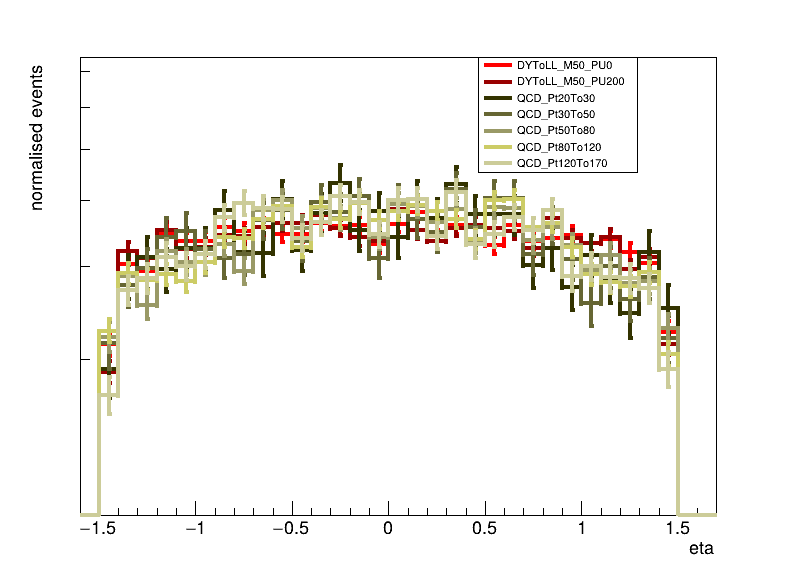

Info in <TCanvas::Print>: png file nb_plots/TkEleL2_2025_04_30_15_45_52.png has been created


In [50]:
etavarlist = ['TkEleL2_GenElgenEBmatched_eta']*2 + ['TkEleL2TkElPt10EB_eta']*5
etaplot = plotmc(etavarlist, 
                np.arange(-1.5, 1.7, 0.1),
                logy=True, normalise=True)
display(Image(filename=etaplot))

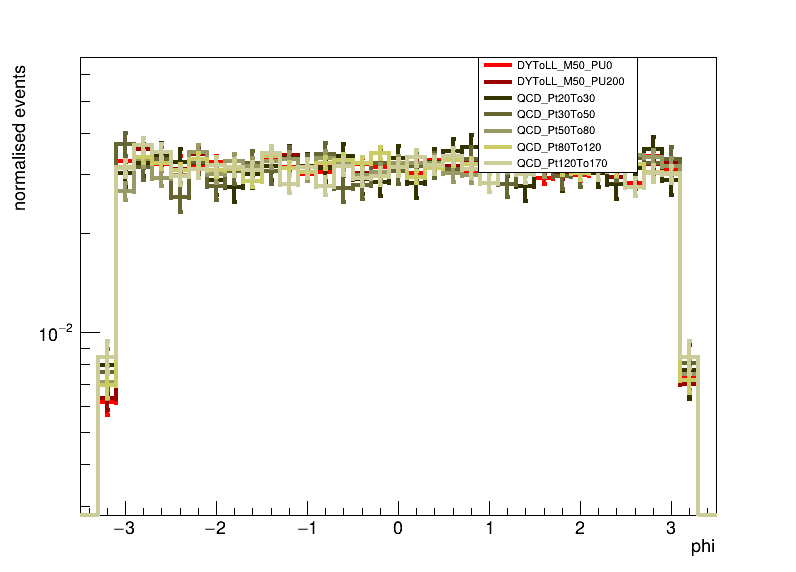

Info in <TCanvas::Print>: png file nb_plots/TkEleL2_2025_04_30_15_45_54.png has been created


In [51]:
phivarlist = ['TkEleL2_GenElgenEBmatched_phi']*2 + ['TkEleL2TkElPt10EB_phi']*5
phiplot = plotmc(phivarlist, 
                np.arange(-3.3, 3.5, 0.2),
                logy=True, normalise=True)
display(Image(filename=phiplot))